# ROM 102 - Practical Considerations

In ROM 101, we learned about reduced order models (**ROM**s), proper orthogonal decomposition (**POD**), and **Galerkin** projection, and we saw the results of some applications of **POD-Galerkin ROM**s.  

In this lecture, we'll 

  1. describe transient heat conduction in a nuclear reactor fuel element
  2. construct a full-order model (**FOM**) for this application using a finite-difference (**FD**) approximation 
  3. construct a corresponding POD-Galerkin ROM
  4. analyze 

# Application: Transient Conduction

The conduction of heat in solids can be described by

$$
  \rho(\mathbf{r})c_p(\mathbf{r}, T) \frac{\partial T}{\partial t} 
    = \nabla k(\mathbf{r}, T) \nabla T(\mathbf{r}, t) + q'''(\mathbf{r}, t) \, .
    \tag{1}
$$

where $T$ is temperature, $\rho$ is density, $c_p$ is specific heat, $k$ is thermal conductivity, and $q'''$ is the volumetric heat generation rate.

As an example application, consider the conduction of heat in a nuclear reactor fuel element.  A fuel element is typically a long cylinder ($L=3$ m; $D = 0.9$cm) made of ceramic UO$_2$ fuel enclosed in a thin ($\Delta = 0.1$ cm) metallic sheath called the cladding.  Often, there is a small gap between the fuel and the cladding filled with an inert gas like argon.  Reactions from fission in the fuel leads to local heating, and, given the volumetric fission rate $f(\mathbf{r}, t)$, the heat generation rate is $q''' = \kappa f$ where $\kappa$ is a conversion factor. These fuel elements are most often assembled in relatively tight ($1.2$ cm center-to-center), vertical clusters cooled by forced flow of water through the channels formed by the exterior of the cladding.

For simplicity, we'll consider thin plate fuel elements in which conduction occurs only along the $x$ axis, or

$$
  \rho(x)c_p(x, T) \frac{\partial T}{\partial t} 
    = \frac{\partial}{\partial x} \left ( k(x, T) \frac{\partial}{\partial x}  T(x, t)\right ) + q'''(x, t) \, .
    \tag{2}
$$

In particular, we'll consider a geometry that looks like

```
    |           |        |
    |   UO2     |  CLAD  |   COOLANT
    |           |        |
   x=0         x=x_f    x=x_c
```

and set 

$$
   q''(0) = 0
   \tag{3}
$$

and 

$$
  q''(x_c) = h(T(x_c)-T_{cool}) \, .
  \tag{4}
$$ 

In other words, we're treating a single plate element with a fixed, convective condition at the coolant boundary.

# Full-Order Model via Finite Differences

To solve (2), we'll use the finite-difference method.  For simplicity, we will determine the temperature at the following fixed spatial points and times:

$$
   x_i = i \Delta_x, \quad i = 0, 1, \ldots, N_x \qquad \text{\qquad} t_j = j \Delta_t,  \quad j = 0, 1, \ldots N_t \, .
   \tag{5}
$$

Now, expand the first term on the right-hand side of (2) and approximate the resulting form using central first and second differences:

$$
\begin{split}
   \frac{\partial}{\partial x} \left ( k(x, T) \frac{\partial}{\partial x}  T(x, t)\right )
     &=  \frac{\partial k}{\partial x}  \frac{\partial T}{\partial x}
          + k(x, T) \frac{\partial^2 T}{\partial x^2}  \\
     &\approx \left ( \frac{k_{i+1}(T_{i+1}(t)) - k_{i-1}(T_{i-1}(t))}{2\Delta_x}  \right ) 
              \left ( \frac{T_{i+1}(t) - T_{i-1}(t)}{2\Delta_x} \right ) \\
     &+ k_{i}(T_{i}(t)) \left ( \frac{T_{i+1}(t) - 2T_{i}(t) +T_{i-1}(t)}{\Delta_x^2} \right ) \, .
\end{split}
\tag{6}
$$

where $T_{i}(t) = T(x_i, t)$ and $k_i(T_i(t)) = k(x_i, T_i(t))$.

Then,

$$
\begin{split}
 \frac{\partial T_i}{\partial t} 
  = & \left ( \frac{k_{i+1}(T_{i+1}(t)) - k_{i-1}(T_{i-1}(t))}{2\Delta_x  \rho_i c_{p,i}(T_i(t))}  \right ) 
              \left ( \frac{T_{i+1}(t) - T_{i-1}(t)}{2\Delta_x} \right ) \\
     &+ k_{i}(T_{i}(t)) \left ( \frac{T_{i+1}(t) - 2T_{i}(t) +T_{i-1}(t)}{\Delta_x^2  \rho_i c_{p,i}(T_i(t))} \right ) 
      + \frac{1}{\rho_i c_{p,i}(T_i(t))} q_i'''\, .
\end{split}
\tag{6}
$$

or

$$
  \frac{d \mathbf{u}}{dt} = \mathbf{A}(\mathbf{u}) \mathbf{u}(t) +\mathbf{B}(\mathbf{u}) \mathbf{q}'''
  \tag{7}
$$

where $\mathbf{u}$ is the vector of temperatures

Substitution of (6) into (2) leads to

$$
\begin{split}
\rho_i c_{p,i}(T_{i,j+1}) \left ( \frac{T_{i,j+1}-T_{i,j}}{\Delta t} \right )
 &= \left(\frac{k_{i+1}(T_{i+1, j+1}) - k_{i-1}(T_{i-1, j+1})}{2\Delta_x} \right ) \left (  \frac{T_{i+1, j+1} - T_{i-1, j+1}}{2\Delta_x}\right ) \\
 &+ k_{i}(T_{i, j+1}) \left( \frac{T_{i+1, j+1} - 2T_{i, j+1} +T_{i-1, j+1}}{\Delta_x^2} \right )\, ,
\end{split}
\tag{7}
$$

where now, e.g., $T_{i,j} = T(x_i, t_j)$.



Finally, at the left, we have 

$$
   \frac{\partial T}{\partial x} \Bigg |_{x=0} = 0 \longrightarrow T_{1, j} - T_{0, j} = 0 \, , \quad \forall j
   \tag{8}
$$

and

$$
   T(L) = 0 \longrightarrow T_{N, j} = 0 \, , \quad \forall j
   \tag{9}
$$

The treatment of non-homogeneous boundary conditions is a bit more complex.

In [45]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
def A(x, T, f_k, f_c_p, f_rho):
    """Generate conduction problem system matrix given constants and temperature.

    Args:
    
        fk (_type_): function k(x, )
        fc_p (_type_): _description_
        frho (_type_): _description_
        T (_type_): _description_
    """

    assert len(x) == len(T)
    n = len(x)

    Δx = x[1] - x[0]

    # Generate discrete values of constants
    k = f_k(x, T)
    c_p = f_c_p(x, T)
    rho = f_rho(x)

    # Initialize system matrix
    A = np.zeros((n, n))

    # Left boundary condition
    A[0, 0] = -1
    A[0, 1] = 1

    # Right boundary condition
    A[-1, -1] = 1

    for i in range(1, n-1):
        a = (k[i+1] - k[i-1])/(4*Δx*rho[i]*c_p[i])
        b = k[i] / (Δx**2*rho[i]*c_p[i])
        A[i, i-1] = -a+b
        A[i, i]   = -2*b
        A[i, i+1] = a 

    return A 

In [184]:
fk = lambda x, T: 10.0*x**0  # W/m-K
fc_p = lambda x, T: 300.0*x**0 # K/J-kg
frho = lambda x: 10970*x**0 # kg/m^3  

In [203]:
x = np.linspace(0, 1, 101)
x

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [218]:
T = 1*x**0
T0 = T
T0[x>0.5] = 0

In [219]:
n = len(T)
Δx = x[1] - x[0]

# Generate discrete values of constants
k = fk(x, T)
c_p = fc_p(x, T)
rho = frho(x)

# Initialize system matrix
A = np.zeros((n, n))

# Left boundary condition
A[0, 0] = -1
A[0, 1] = 1

# Right boundary condition
A[-1, -1] = 1


for i in range(1, n-1):
    a = (k[i+1] - k[i-1])/(4*Δx*rho[i]*c_p[i])
    b = k[i] / (Δx**2*rho[i]*c_p[i])
    A[i, i-1] = -a+b
    A[i, i]   = -2*b
    A[i, i+1] = a+b

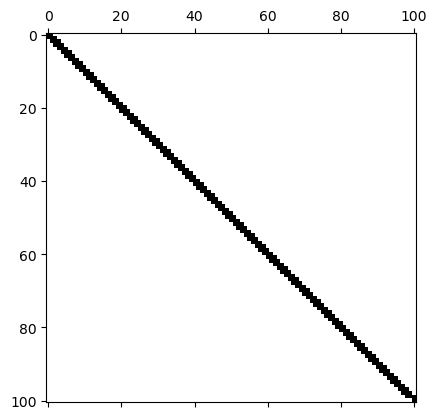

In [220]:
plt.spy(A)

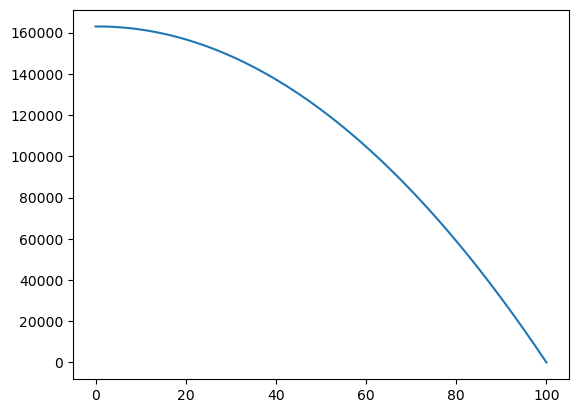

In [221]:
plt.plot(np.linalg.solve(A, -np.ones(n)))

In [222]:
from scipy.integrate import odeint

In [223]:
def func(T, t):
   return A@T

times = np.linspace(0, 0.1)


sol = odeint(func, y0=T0, t=times)

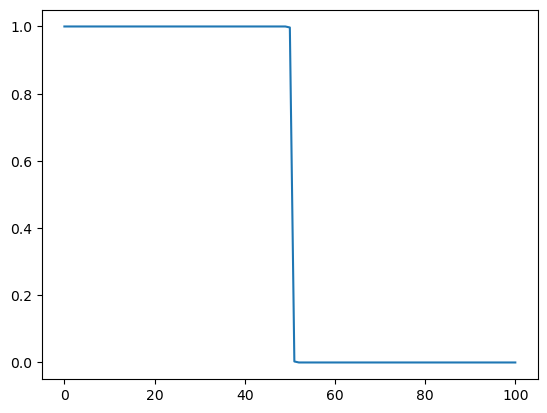

In [224]:
plt.plot(sol[-1, :])

In [225]:
n

101

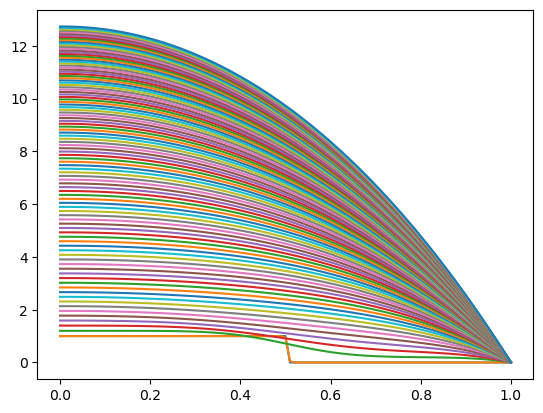

In [226]:
# euler
T0 = np.ones(n)
T0[x>0.5] = 0.0
#T0 = 1 - x
I = np.eye(n)
dt = 2
Told = T0*1


q=np.ones(n)*1e-4
q[0] = 0; q[-1] = 0;

plt.plot(x, Told)
for i in range(100000):
    Tnew = np.linalg.solve( (I-dt*A), Told + dt*q )
    Told = Tnew
    if (i%1000 == 0):
        plt.plot(x, Tnew)

In [227]:
Told

array([12.78834708, 12.78837358, 12.78598134, 12.78117014, 12.77393952,
       12.76428884, 12.75221721, 12.73772355, 12.72080655, 12.70146468,
       12.6796962 , 12.65549917, 12.6288714 , 12.59981052, 12.56831392,
       12.53437879, 12.49800212, 12.45918067, 12.41791098, 12.37418941,
       12.32801209, 12.27937495, 12.22827371, 12.17470388, 12.11866078,
       12.0601395 , 11.99913495, 11.93564184, 11.86965467, 11.80116773,
       11.73017515, 11.65667082, 11.58064847, 11.50210161, 11.4210236 ,
       11.33740756, 11.25124646, 11.16253306, 11.07125996, 10.97741956,
       10.88100408, 10.78200557, 10.6804159 , 10.57622677, 10.4694297 ,
       10.36001604, 10.24797698, 10.13330354, 10.01598657,  9.89601677,
        9.77338468,  9.64808067,  9.52009497,  9.38941766,  9.25603865,
        9.11994773,  8.98113452,  8.83958852,  8.69529909,  8.54825543,
        8.39844663,  8.24586164,  8.09048929,  7.93231826,  7.77133715,
        7.60753439,  7.44089834,  7.27141721,  7.09907911,  6.92

In [214]:
T0

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [215]:
q=np.ones(n)*1e-4
q[0] = 0; q[-1] = 0;
np.linalg.solve(-A, q)

array([ 0.148095,  0.148095,  0.144804,  0.138222,  0.128349,  0.115185,
        0.09873 ,  0.078984,  0.055947,  0.029619, -0.      ])